# xAI Wake Classifier - Training and Testing

## Required data (run to download the xAI Wakes dataset yet)
* For the .csv with the target values for training and a set of pretrained weights, go to: https://drive.google.com/drive/folders/1CUIQy77qIsx2vIdJB7D95UEzCv5_YZDL?usp=sharing
* For the dataset, run the following code:

In [ ]:
import requests
from tqdm import tqdm

def download_file(url, filename):
    """
    Download a file from the specified URL and save it locally.
    """
    # Send a GET request to the URL
    response = requests.get(url, stream=True)

    # Total size in bytes
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    with open(filename, 'wb') as file, tqdm(
        total=total_size, unit='iB', unit_scale=True
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

# URL of the file to be downloaded
url = "https://zenodo.org/records/10018939/files/xAIWakes.zip?download=1"

# Local filename to save the downloaded file
filename = "xAIWakes.zip"

# Download the file
download_file(url, filename)

print(f"Downloaded '{filename}'.")

* Extract the downloaded dataset:

In [ ]:
import zipfile

# Specify the path to the zip file and the extraction directory
zip_path = 'xAIWakes.zip'
extract_to = 'xAIWakes'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## Imports

In [1]:
from typing import Any

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.types import STEP_OUTPUT
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

import torchvision
import torchvision.transforms
import torchvision.transforms as transforms
from torchvision.transforms import v2

import torchmetrics
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix

import numpy
import numpy as np
from numpy import logspace

import PIL
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime # Used only to name savefig of confusion matrix
import pandas as pd
import os
from skimage import io
import tifffile
from pathlib import Path
import imageio.v2 as imageio

## Configuration

In [2]:
# Random seed
SEED = 41

# Training hyperparameters
IN_CHANNELS = 4
NUM_CLASSES = 2
LEARNING_RATE = 0.000310823572 # Obtained through Grey Wolf Optimization
BATCH_SIZE = 21 # Obtained through Grey Wolf Optimization
NUM_EPOCHS = 21

# Dataset
DATA_DIR = rf'xAIWakes/xAIWakes/'
CSV_DIR = rf'xAIWakes_dataset.csv'

NUM_WORKERS = 0 # 4
TRANSFORM = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])
TRANSFORM_SIMPLE = torchvision.transforms.ToTensor()

# Compute related
ACCELERATOR = "gpu" # Change to use cpu
DEVICES = [0]
#PRECISION = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Change ACCELLERATOR to use this

# Logs
LOGS_DIR = rf"tb_logs"
CONF_MATRIX_DIR = rf"tb_logs"

## Dataloader

* Transform the xAIWakes dataset to suit the network

In [3]:
def read_img(idx):
    
    def correct_dim(img):
        # If the image is not already in grayscale, convert it
        if len(img.shape) == 3 and img.shape[2] == 3:  # Assuming the image is RGB
            img_gray = img[:, :, 0]
        else:
            img_gray = img
        return img_gray

    resize_transform = transforms.Resize((256,256), antialias=True)

    b2 = [x for x in Path('xAIWakes/xAIWakes/B2').glob('**/*') if x.is_file()]
    b3 = [x for x in Path('xAIWakes/xAIWakes/B3').glob('**/*') if x.is_file()]
    b4 = [x for x in Path('xAIWakes/xAIWakes/B4').glob('**/*') if x.is_file()]
    b8 = [x for x in Path('xAIWakes/xAIWakes/B8').glob('**/*') if x.is_file()]

    # Exclude unwanted indices
    exclude_indices = [4, 80, 84, 87]  # Because B2 no_wake has some images in excess
    b2 = [b2[i] for i in range(len(b2)) if i not in exclude_indices] # Because B2 no_wake has some images in excess
    
    b2_idx = b2[idx]
    b3_idx = b3[idx]
    b4_idx = b4[idx]
    b8_idx = b8[idx]

    #TEST
    im_b2 = imageio.imread(b2_idx)
    im_b3 = imageio.imread(b3_idx)
    im_b4 = imageio.imread(b4_idx)
    im_b8 = imageio.imread(b8_idx)

    # Correct the dimensions
    im_b2 = correct_dim(im_b2)
    im_b3 = correct_dim(im_b3)
    im_b4 = correct_dim(im_b4)
    im_b8 = correct_dim(im_b8)
    
    # Convert NumPy arrays to PIL Images
    im_b2 = Image.fromarray(im_b2)
    im_b3 = Image.fromarray(im_b3)
    im_b4 = Image.fromarray(im_b4)
    im_b8 = Image.fromarray(im_b8)
    
    # Apply resizing transformation
    im_b2 = resize_transform(im_b2)
    im_b3 = resize_transform(im_b3)
    im_b4 = resize_transform(im_b4)
    im_b8 = resize_transform(im_b8)
    
    im_stack = np.stack((im_b2, im_b3, im_b4, im_b8), axis=0)
    #print("CHECK:", im_stack.shape)
    return im_stack.astype(np.float32)

class xAIWakesDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        super().__init__()
        self.annotations = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations) # XAI has 269 images

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = read_img(index)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))       
        
        if self.transform:
            image = self.transform(image)

        image = image.permute(1, 0, 2)
        #print("CHECK_2:",image.shape)
        return (image, y_label)

* Define the Lightning data module
* Dataset split as 60% Training, 20% for validation and testing.

In [19]:
class xAIWakesDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, root_dir, batch_size, num_workers, transform=None):
        super().__init__()
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def prepare_data(self):
        # Left empty as data is already downloaded and preprocessed
        pass

    def setup(self, stage):
        my_ds = xAIWakesDataset(self.csv_file, self.root_dir, self.transform)
        self.train_ds, self.val_ds, self.test_ds = random_split(my_ds, [0.6, 0.2, 0.2])
        self.predict_ds = my_ds

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            #persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            #persistent_workers=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            #persistent_workers=True,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            #persistent_workers=True,
        )

## Model

In [5]:
class CommonConv(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

In [6]:
class WakeClassifier(nn.Module):
    def __init__(self, in_channels=4, num_classes=2):
        super().__init__()
        self.conv_layers = nn.Sequential(
            CommonConv(in_channels=in_channels, out_channels=16),
            CommonConv(in_channels=16, out_channels=32),
            CommonConv(in_channels=32, out_channels=64),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 32 * 32, 512),  # Adjust input size based on your image dimensions
            nn.ReLU(),
            nn.Linear(512, num_classes),  # Output layer with 2 classes
            nn.Dropout(p=0.4),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [11]:
class WakeClassifierPlModule(pl.LightningModule):
    def __init__(self, in_channels=4, num_classes=2, learning_rate=1e-3):
        super(WakeClassifierPlModule, self).__init__()
        self.lr = learning_rate
        self.model = WakeClassifier(num_classes=2)

        # Other
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = BinaryAccuracy()
        self.test_accuracy = 0.0 # for hyperparameter optimization
        self.f1_score = BinaryF1Score()
        self.conf_matrix = BinaryConfusionMatrix()
        self.conf_matrix_pred = BinaryConfusionMatrix()

    def forward(self, x):
        # Convolutional layers with ReLU activation, batch normalization, and max pooling
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(torch.argmax(scores, dim=1), y)
        f1_score = self.f1_score(torch.argmax(scores, dim=1), y)
        self.log_dict({
            'train_loss': loss, 
            'train_accuracy': accuracy,
            'train_f1_score': f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
            )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        self.accuracy.update(torch.argmax(scores, dim=1), y)
        self.f1_score.update(torch.argmax(scores, dim=1), y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(torch.argmax(scores, dim=1), y)
        f1_score = self.f1_score(torch.argmax(scores, dim=1), y)
        self.conf_matrix.update(torch.argmax(scores, dim=1), y)
        self.conf_matrix.compute()
        self.log_dict({
            'test_loss': loss, 
            'test_accuracy': accuracy,
            'test_f1_score': f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
            )
        return loss

    def on_test_end(self):
        fig_, ax_ = self.conf_matrix.plot()  # to plot and save confusion matrix
        plt.xlabel('Prediction')
        plt.ylabel('Class')
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plt.savefig(rf".\tb_logs\confusion_matrix_{current_datetime}.png")
        #plt.show()

    def _common_step(self, batch, batch_idx):
        x, y = batch
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        return loss, scores, y
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        accuracy = self.accuracy(preds, y)
        f1_score = self.f1_score(preds, y)
        self.conf_matrix_pred.update(preds, y)
        self.conf_matrix_pred.compute()

        print(f" - Accuracy: {accuracy:.3f}, F1-score: {f1_score:.3f}")
        return preds

    def on_predict_end(self):
        fig_, ax_ = self.conf_matrix_pred.plot()
        plt.xlabel('Prediction')
        plt.ylabel('Class')
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plt.savefig(rf".\tb_logs\confusion_matrix_predictions_{current_datetime}.png")
        plt.show()  # test block=False

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr) # 1e-3 is a sane value for lr
        return optimizer

#### Tensor shape test
Useful to see if the model takes in a tensor with the correct shape, and returns the correct amount of classes. In this case, the desired output is "torch.Size([4, 2])"

In [12]:
# Basic check
model = WakeClassifier()
x = torch.randn(4, 4, 256, 256)
print(model(x).shape)

torch.Size([4, 2])


## Training

Note: workers are set to 0 and are set to not be persistent in the dataloaders because of some issue with notebook. For information on this issue, refer to this (https://github.com/pytorch/pytorch/issues/5301)

* For reproducibility's sake, it is important to set the seed for all pseudo-random processes

In [17]:
seed = pl.seed_everything(seed=SEED, workers=True) # For reproducibility
torch.set_float32_matmul_precision("medium") # to make lightning happy

Seed set to 41


In [18]:
logger = TensorBoardLogger(save_dir=LOGS_DIR, name=f"wakeclassifier_model_dropout_v0_lr{LEARNING_RATE}_bs{BATCH_SIZE}")
#profiler = PyTorchProfiler(
#    on_trace_ready=torch.profiler.tensorboard_trace_handler("tb_logs/profiler0"),
#    schedule=torch.profiler.schedule(skip_first=5, wait=1, warmup=1, active=20),
#)
model = WakeClassifierPlModule(
    in_channels=IN_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
)
dm = xAIWakesDataModule( # self, csv_file, root_dir, batch_size, num_workers, transform=None)
    csv_file=CSV_DIR,
    root_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform=TRANSFORM_SIMPLE,
)
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=NUM_EPOCHS,
    fast_dev_run=False, #check for a fast run 
    overfit_batches=False, # check to overfit a batch. Do this before trying to train on the whole dataset
    logger=logger,
    log_every_n_steps=5,
    check_val_every_n_epoch=5,
    #profiler=profiler,
    #callbacks=[cb],
)
trainer.fit(model, dm)
trainer.validate(model, dm)
results = trainer.test(model, dm)
print("The test accuracy is: ", results[0].get('test_accuracy'))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                  | Params
-----------------------------------------------------------
0 | model            | WakeClassifier        | 33.6 M
1 | loss_fn          | CrossEntropyLoss      | 0     
2 | accuracy         | BinaryAccuracy        | 0     
3 | f1_score         | BinaryF1Score         | 0     
4 | conf_matrix      | BinaryConfusionMatrix | 0     
5 | conf_matrix_pred | BinaryConfusionMatrix | 0     
-----------------------------------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.319   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\deeplearning\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\andre\anaconda3\envs\deeplearning\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\andre\anaconda3\envs\deeplearning\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 8/8 [00:20<00:00,  0.38it/s, v_num=2]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:18<00:00,  0.44it/s, v_num=2, train_loss=7.930, train_accuracy=0.503, train_f1_score=0.411]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:18<00:00,  0.44it/s, v_num=2, train_loss=5.300, train_accuracy=0.615, train_f1_score=0.525]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:18<00:00,  0.44it/s, v_num=2, train_loss=2.440, train_accuracy=0.733, train_f1_score=0.665]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 8/8 [00:18<00:00,  0.42it/s, v_num=2, train_loss=0.678, train_accuracy=0.776, train_f1_score=0.708]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 8/8 [00:17<00:00,  0.46it/s, v_num=2, train_loss=0.609, train_accuracy=0.851, train_f1_score=0.829]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 8/8 

`Trainer.fit` stopped: `max_epochs=21` reached.


Epoch 20: 100%|██████████| 8/8 [00:25<00:00,  0.32it/s, v_num=2, train_loss=0.138, train_accuracy=0.913, train_f1_score=0.895]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\andre\anaconda3\envs\deeplearning\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 3/3 [00:03<00:00,  0.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.1895912885665894
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\andre\anaconda3\envs\deeplearning\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:03<00:00,  0.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.849056601524353
      test_f1_score         0.7799917459487915
        test_loss            1.080797553062439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
The test accuracy is:  0.849056601524353


## Testing

* Currently set to do inference on a the whole dataset. Change the predict_step, the predict dataloader, etc. to change this. 
* Download pre-trained weights from here: https://drive.google.com/uc?export=download&id=1NfR57Liq_1-lplvjsxMLUaB_64A8PFSD

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at epoch=19-step=160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at epoch=19-step=160.ckpt
C:\Users\andre\anaconda3\envs\deeplearning\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 13/13 [00:13<00:00,  0.96it/s]


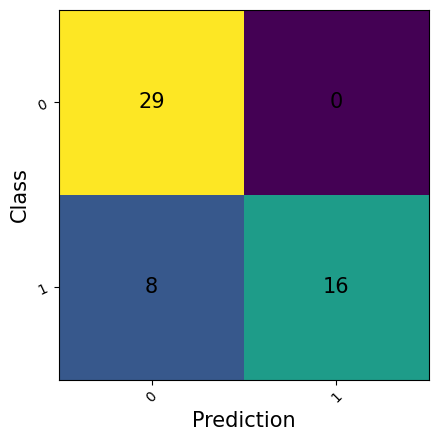

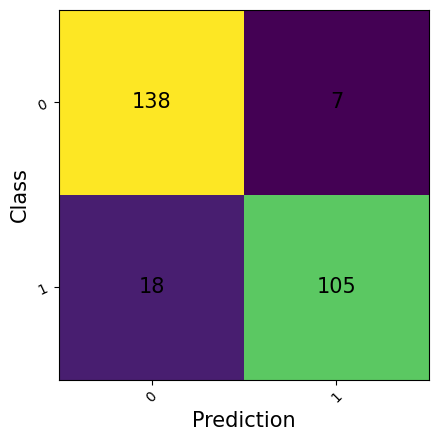

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]),
 tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]),
 tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]),
 tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]

In [20]:
model = WakeClassifierPlModule(
    in_channels=IN_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE
)
dm = xAIWakesDataModule( # self, csv_file, root_dir, batch_size, num_workers, transform=None)
    csv_file=CSV_DIR,
    root_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform=TRANSFORM,
)
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=NUM_EPOCHS,
    log_every_n_steps=5,
    inference_mode=True,
)
trainer.predict(
    model=model,
    datamodule=dm,
    ckpt_path=rf"epoch=19-step=160.ckpt",
)